Following Khomyakov's trouble-shooting tips in https://arxiv.org/pdf/cond-mat/0501609.pdf

In [8]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

from dataclasses import dataclass
import RGF_single_orbital as so
import RGFtools as rg
@dataclass
class JosephsonParameters:
    W : int
    L : int
    a : float
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float
    tol: float
from scipy.linalg import orth

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
params = JosephsonParameters(W = 10 , 
                             L = 10,
                             t = 1,
                             a = 1 , 
                             flux = 0.0,
                             energy = 0.5,
                             Delta = 0,
                             phase = 0,
                             mu = 0.5,
                            tol = 1e-4)



In [18]:
import scipy
def mode_sorting(eigenvalues , eigenvectors , params , slice):
    # each eigenvector is formed of amplitudes (c_{i} , c_{i-1}). We want the lower block:
    vectors = eigenvectors[int(eigenvectors.shape[0]/2) : , :]

    # We now want a matrix of norms. The column vectors in vectors may not necessarily be orthogonal but this is fine.
    norms = np.diagonal(np.conj(vectors.T) @ vectors)
    normalisation_factors = 1 / np.sqrt(norms)
    normalisation_factor_matrix = np.diag(normalisation_factors)

    normalised_vectors = vectors @ normalisation_factor_matrix

    # Eigenvalues corresponding to states that decay in the positive x direction:
    pos_e_evals = eigenvalues[(np.abs(eigenvalues) - 1) < -params.tol]
    # Eigenvalues corresponding to states that evanesce in the negative x direction:
    neg_e_evals = eigenvalues[(np.abs(eigenvalues) - 1) > params.tol]

    # Compute the group velocity for each state:
    group_velocities = np.zeros(vectors.shape[1])
    for i in range(vectors.shape[1]):
        group_velocities[i] = so.group_vel(normalised_vectors[: , i], eigenvalues[i] , slice , params)

    # Sorting propagating modes according to sign of group velocity:
    p_conditions = (np.abs((np.abs(eigenvalues) - 1)) <= params.tol) & (group_velocities > 0)
    n_conditions =(np.abs((np.abs(eigenvalues) - 1)) <= params.tol) & (group_velocities < 0 )

    pos_p_evals = eigenvalues[p_conditions]
    neg_p_evals = eigenvalues[n_conditions]

    # Sorting normalised eigenvectors in the same way:
    pos_prop = normalised_vectors[: , p_conditions]
    neg_prop = normalised_vectors[: , n_conditions]

    pos_evanesce = normalised_vectors[: , (np.abs(eigenvalues) - 1) < -params.tol]
    neg_evanesce = normalised_vectors[: , (np.abs(eigenvalues) - 1) > params.tol]
    
    list_of_eigenvalues = [pos_p_evals , neg_p_evals , pos_e_evals , neg_e_evals]

    # group_velocities for propgating states only:
    g_vel_p = group_velocities[p_conditions]
    g_vel_n = group_velocities[n_conditions]
     
    return pos_prop , neg_prop , pos_evanesce , neg_evanesce , list_of_eigenvalues , [group_velocities , g_vel_p , g_vel_n]
    
def generalised_eigenvalue_problem(slice , params):
    energy = params.energy
    M00 = np.linalg.inv(so.T(slice+1 , -1, params))@(energy*np.identity(params.W) -  so.h_0(slice , params)) # <- Calculating the Hamiltonian at slice.
    M01 = -np.linalg.inv(so.T(slice+1 , -1, params))@so.T(slice , +1 , params)
    M10 = np.identity(params.W)
    M11 = np.zeros(shape = (params.W , params.W))

    M = np.block([[M00 , M01],[M10 , M11]]) #<- Matrix to diagonalise for propagating modes in lead


    ## TESTING GENERALISED EIGENVALUE FORMULATION:
    # # Left Matrix:
    # M_00 = (energy*np.identity(params.W) -  so.h_0(slice , params))
    # M_01 = -so.T(slice , +1 , params)
    # M_10 = np.identity(params.W)
    # zeros = np.zeros(shape = (params.W , params.W))
    # M_11 = zeros
    # M = np.block([[M_00 , M_01],[M_10 , M_11]])
    # # Right matrix
    # N = np.block([[so.T(slice+1 , -1 , params) , zeros],[zeros , np.identity(params.W)]])

    # evals are bloch factors, evecs are transverse mode eigenvfunctions for sites: (slice , slice -1)^{T}
    evals , evecs = scipy.linalg.eig(M)

    pos_prop , neg_prop , pos_evanesce , neg_evanesce , list_of_eigenvalues , gv = mode_sorting(evals , evecs ,params , slice)

    # Constructing U(±), matrices of right and left going eigenvectors:
    U_pos = np.hstack((pos_prop , pos_evanesce))
    U_neg = np.hstack((neg_prop , neg_evanesce)) 

    # Constructing A(±) , diagonal matrix of bloch factors:
    Lambda_pos = np.diag(np.hstack((list_of_eigenvalues[0] ,list_of_eigenvalues[2])))
    Lambda_neg = np.diag(np.hstack((list_of_eigenvalues[1] , list_of_eigenvalues[3])))

    # Construct the F(\pm) transfer matrices:
    F_pos = U_pos @ Lambda_pos @ np.linalg.inv(U_pos)
    F_neg = U_neg @ Lambda_neg @ np.linalg.inv(U_neg)

    F_pos_prop_only = pos_prop @ np.diag(list_of_eigenvalues[0])@np.linalg.pinv(pos_prop)
    F_neg_prop_only = neg_prop @ np.diag(list_of_eigenvalues[1])@np.linalg.pinv(neg_prop)

        # This is for diagnostic purposes:
    debugdict = {'U_pos' : U_pos , 'U_neg' : U_neg , 'Lambda_pos' : Lambda_pos , 'Lambda_neg': Lambda_neg
                 , 'pos_prop' : pos_prop , 'neg_prop' : neg_prop , 'pos_evanesce' : pos_evanesce , 'neg_evanesce' : neg_evanesce
                 ,'list_of_eigenvalues' : list_of_eigenvalues , 'group_velocities' : gv, 'evals': evals , 'evecs': evecs , 
                 'F_pos_prop': F_pos_prop_only , 'F_neg_prop' : F_neg_prop_only}

    return F_pos , F_neg , debugdict

def compute_transmission_matrix(lead_indices , params):
    """
    Uses the recursive Greens function algorithm to compute diagonal and off-diagonal Greens functions between the two leads.

    Arguments:
    lead_indices: list , indices of lead slices that are connected to the scattering region.
    params: system parameters 

    returns:
    [GF_diagonal , GF_off_diagonal] : list , diagonal and off-diagonal greens functions for the system.
    """

    # Indices of site in left and right lead that are connected to the scattering region:
    #  Lead  *  Scattering  * Lead
    # -L-L-L-L-S-S-S...-S-S-R-R-R-R-
    #       -0-1-2-3.....-L-L+1

    slice_left = lead_indices[0]
    slice_right = lead_indices[1]

    F_pos_left , F_neg_left , debug_left = generalised_eigenvalue_problem(slice_left - 1 , params)
    F_pos_right , F_neg_right , debug_right = generalised_eigenvalue_problem(slice_right + 1 , params)

    F_pos_left_prop = debug_left['F_pos_prop']
    F_neg_left_prop = debug_left['F_neg_prop']
    F_pos_right_prop = debug_right['F_pos_prop']
    F_neg_right_prop = debug_right['F_neg_prop']
    
    H_start_tilde = so.h_0(slice_left , params) + so.T(slice_left , +1 , params)@scipy.linalg.inv(F_neg_left)
    H_end_tilde = so.h_0(slice_right , params) + so.T(slice_right+1 , -1 , params)@F_pos_right

    # Number of slices in the scattering region + adjacent slices in lead:
    no_steps = params.L + 2
    
     # Storing tilde Hamiltonians in an array:
    H_tildes = np.zeros(shape = ( H_start_tilde.shape[0] , H_start_tilde.shape[0] , no_steps))
    H_tildes[: , : , 0] = H_start_tilde
    H_tildes[: , : ,-1] = H_end_tilde
    for j in range(1,params.L + 1):
        H_tildes[: , : , j] = so.h_0(j , params)

    # Source term at the left lead:
    source_term = so.T(slice_left , +1 , params) @ (scipy.linalg.inv(F_pos_left) - scipy.linalg.inv(F_neg_left))

    # Recursive step:
    G_start = scipy.linalg.inv(params.energy*np.identity(params.W) - H_start_tilde)    
    diag_greensfunctions = np.zeros(shape = (params.W , params.W , no_steps) , dtype = np.complex128)
    off_diag_greensfunctions = np.zeros(shape = (params.W , params.W , no_steps), dtype = np.complex128)
    
    # Initial condition:
    diag_greensfunctions[: , : , 0] = G_start
    off_diag_greensfunctions[: , : , 0] = G_start

    for i in range(no_steps):
        if i > 0:
            matrix = (params.energy*np.identity(params.W)  - H_tildes[: , : , i] -
                            (so.T(i , +1 , params) @ diag_greensfunctions[: , : , i-1] @ so.T(i , -1 , params)) )
            diag_greensfunctions[: , : , i] = scipy.linalg.inv(matrix)
            off_diag_greensfunctions[: , : , i] = diag_greensfunctions[: , : , i] @ so.T(i , +1 , params) @ off_diag_greensfunctions[: , : , i-1]
        
    U_pos_left = debug_left['U_pos']
    U_pos_right = debug_right['U_neg']
    
    # Non-physical transmission matrix (includes matrix elements between evanescent waves too, so not physical):  
    tau = scipy.linalg.inv(U_pos_right)@off_diag_greensfunctions[: , : , -1]@source_term@U_pos_left

    # For the physical transmission matrix, we must compute matrix-elements only between propagating states:
    U_pos_prop_left = debug_left['pos_prop']
    U_neg_prop_left = debug_left['neg_prop']
    U_pos_prop_right = debug_right['pos_prop']

    transmission = scipy.linalg.pinv(U_pos_prop_right) @  off_diag_greensfunctions[: , : , -1] @ source_term  @ U_pos_prop_left

    # Normalise with respect to group_velocities of propagating modes in each lead:
    g_vel_left = debug_left['group_velocities'][1]
    g_vel_right = debug_right['group_velocities'][1]

    normalisation_matrix = np.sqrt(np.outer(g_vel_right , 1/g_vel_left))

    transmission_normalized = normalisation_matrix * transmission

    debugging = {'m1': tau , 'm2': off_diag_greensfunctions[: , : , -1] @ source_term  , 'm3': np.linalg.pinv(U_pos_prop_right) @ U_pos_prop_left , 
                 'm4': off_diag_greensfunctions[: , : , -1] , 'm5': source_term , 'm6': (diag_greensfunctions[: , : , 0] @ source_term)}
    return transmission , transmission_normalized, normalisation_matrix,  debugging


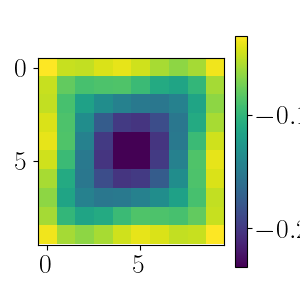

In [23]:
lead_indices = [0 , params.L + 1]
transmission, norm_trans , normalisation_matrix, debugging = compute_transmission_matrix(lead_indices , params)
plt.figure(figsize = (3 , 3))
plt.imshow(np.real(debugging['m4']))
plt.colorbar()


# fig ,ax = plt.subplots(nrows = 1 , ncols = 3)
# ax[0].imshow(np.abs(debugging['m5']))
# ax[1].imshow(np.abs(np.linalg.inv(debugging['m5'])))
# ax[1].set_title(r'$Q_{0}^{-1}$')
# ax[2].imshow(np.abs(debugging['m6']))
# ax[2].set_title(r'$G_{L+1 , 0}$')

3


/var/folders/q7/mt24cx7d41b3712vq5fcskd80000gn/T/ipykernel_2928/2706544299.py:38: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable = im0)


Text(0.5, 1.0, 'Kwant')

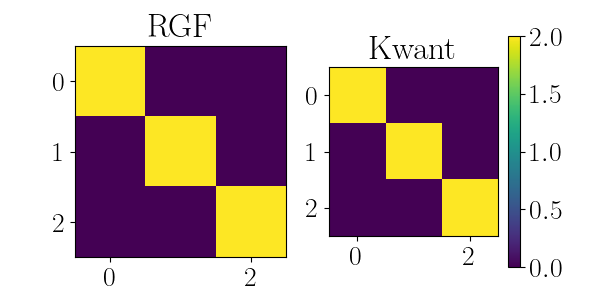

In [20]:
# Modelling the same system in Kwant for comparision:
def kwant_comparision(params):
    syst = kwant.Builder()
    lat = kwant.lattice.square(a = params.a , norbs = 1)

    for i in range(params.L):
        for j in range(params.W):
            syst[lat(i , j)] = 4*params.t - params.mu

            if i > 0:
                syst[lat(i , j) , lat(i-1 , j)] = -params.t
            if j > 0:
                syst[lat(i , j) , lat(i , j-1)] = -params.t

    lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))
    for i in range(params.W):
        lead[lat(0 , i)] = 4*params.t - params.mu
        if i >0:
            lead[lat(0 , i) , lat(0 , i-1) ] = - params.t
        lead[lat(1 , i) , lat(0 , i)] = - params.t

    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    return syst
smatrix = kwant.smatrix(kwant_comparision(params) , energy = params.energy)

num_propagating = smatrix.num_propagating

print(num_propagating(0))

t_block = smatrix.data[smatrix.block_coords(1 , 0)]

fig , ax = plt.subplots(nrows = 1 , ncols = 2)
fig.set_figheight(3)
fig.set_figwidth(6)
im0 = ax[0].imshow(np.abs(norm_trans))
plt.colorbar(mappable = im0)
ax[0].set_title(r'RGF')
im1 = ax[1].imshow(np.abs(t_block))
ax[1].set_title(r'Kwant')



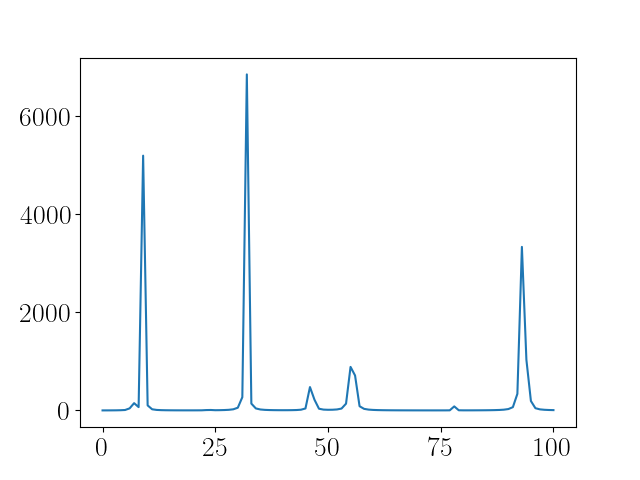

In [28]:
# # Testing conductance calculation:
# energy_values = np.linspace(0 , 1 , 101)
# conductance_values = np.zeros(energy_values.shape[0])
# transmission_matrices = []
# norm_transmission_matrices = []
# normalisation_matrices =[]
# for i in range(len(energy_values)):
#     params.energy = energy_values[i]
#     transmission , norm_transmission , normalisation_matrix = compute_transmission_matrix(lead_indices , params)
#     transmission_matrices.append(transmission)
#     norm_transmission_matrices.append(norm_transmission)
#     normalisation_matrices.append(normalisation_matrix)
#     conductance_values[i] = np.trace(np.conjugate(norm_transmission.T)@norm_transmission)

# plt.figure()
# plt.plot(conductance_values)

In [128]:
# Testing inspecting function:
testcalc = str(np.array([1 , 2, 3 , 4]) + np.array([[1 , 0],[2 , 3]]))

ValueError: operands could not be broadcast together with shapes (4,) (2,2) 